In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#set seaborn plotting aesthetics
sns.set(style='white')

In [2]:
# Import dataset
df = pd.read_csv('../data/mimic_pulseOx_data.csv')
pd.options.display.max_columns = df.shape[1]
df.shape

(81797, 138)

In [3]:
# Column names.
# These match list of dictionary definitions in '../data/mimic_pulseOx_dictionary.csv'
# We will NOT use all of these.
# In fact, we will not use most of the columns, because many require invasive procedures.
# We want our models to be able to more accurately predict SaO2 from SpO2 using only...
# information that individuals could gather at home, ideally.
list(df.columns.values)

['subject_id',
 'stay_id',
 'SaO2_timestamp',
 'SaO2',
 'delta_SpO2',
 'SpO2',
 'hidden_hypoxemia',
 'hadm_id',
 'gender',
 'sex_female',
 'anchor_age',
 'race',
 'race_group',
 'language',
 'insurance',
 'weight',
 'height',
 'BMI',
 'anchor_year_group',
 'first_hosp_stay',
 'first_icu_stay',
 'icustay_seq',
 'admittime',
 'dischtime',
 'icu_intime',
 'icu_outtime',
 'los_hospital',
 'los_icu',
 'CCI',
 'SOFA_admission',
 'mortality_in',
 'delta_vent_start',
 'ventilation_status',
 'invasive_vent',
 'delta_FiO2',
 'FiO2',
 'delta_rrt',
 'rrt',
 'delta_vp_start',
 'norepinephrine_equivalent_dose',
 'delta_sofa_coag',
 'sofa_coag',
 'delta_sofa_liver',
 'sofa_liver',
 'delta_sofa_cv',
 'sofa_cv',
 'delta_sofa_cns',
 'sofa_cns',
 'delta_sofa_renal',
 'sofa_renal',
 'delta_sofa_resp',
 'sofa_resp',
 'delta_hemoglobin',
 'hemoglobin',
 'delta_hematocrit',
 'hematocrit',
 'delta_mch',
 'mch',
 'delta_mchc',
 'mchc',
 'delta_mcv',
 'mcv',
 'delta_platelet',
 'platelet',
 'delta_rbc',
 'rbc',

We will NOT use all of these.
In fact, we will not use most of the columns, because many require invasive procedures.
We want our models to be able to more accurately predict SaO2 from SpO2 using only...
information that individuals could gather at home, ideally.

## Explore characteristics of the 'race_group' variable, with particular attention to category 'Other'

In [4]:
df.race_group.value_counts()

White       55206
Other       15892
Black        5644
Hispanic     2821
Asian        2234
Name: race_group, dtype: int64

In [5]:
# What is contained within "Other" category?
# Let's look at the more specific "race" variable for those patients
df.race[df.race_group == 'Other'].value_counts()

UNKNOWN                                      10519
OTHER                                         2462
UNABLE TO OBTAIN                              1783
PATIENT DECLINED TO ANSWER                     680
AMERICAN INDIAN/ALASKA NATIVE                  286
NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER      112
MULTIPLE RACE/ETHNICITY                         50
Name: race, dtype: int64

In [6]:
# Makes sense that race="OTHER', and also the last three categories above...
# would be placed in race_group='Other', 
# but 'UNKNOWN', 'UNABLE TO OBTAIN', and 'PATIENT DECLINED TO ANSWER' are different. 
# They represent unknown race group, not 'Other' race group.

# Let's correct this for the race_group variable, adding a new category 'Unknown':
# Change race_group to category type
df['race_group'] = df['race_group'].copy().astype('category')

# Add our new category, 'Unknown', for unknown race group
df['race_group'] = df.race_group.cat.add_categories(new_categories = 'Unknown')

### Do the replacements
df.race_group.loc[df.race == 'UNKNOWN'] = 'Unknown'
df.race_group.loc[df.race == 'PATIENT DECLINED TO ANSWER'] = 'Unknown'
df.race_group.loc[df.race == 'UNABLE TO OBTAIN'] = 'Unknown'

# See our new value counts
df.race_group.value_counts()

White       55206
Unknown     12982
Black        5644
Other        2910
Hispanic     2821
Asian        2234
Name: race_group, dtype: int64

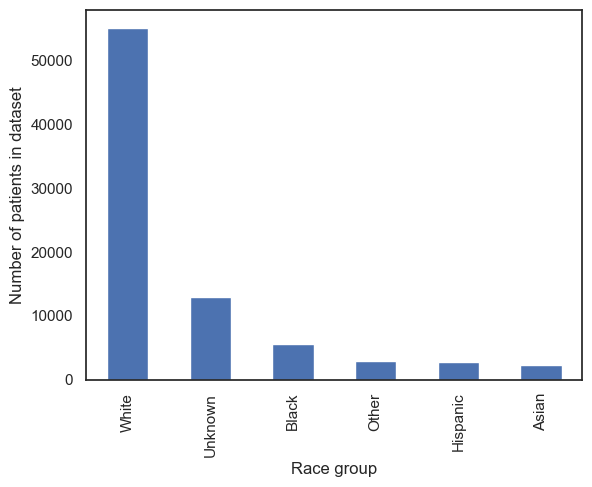

In [7]:
# Plot theses values. This is the racial distribution of patients in our dataset
df.race_group.value_counts().plot.bar()
plt.xlabel("Race group");
plt.ylabel("Number of patients in dataset");

### Findings: Racial distribution of dataset
- We must account for this highly unbalanced distribution (white patients dramatically overrepresented) in our analyses.

# Explore range of values for target variable, SaO2

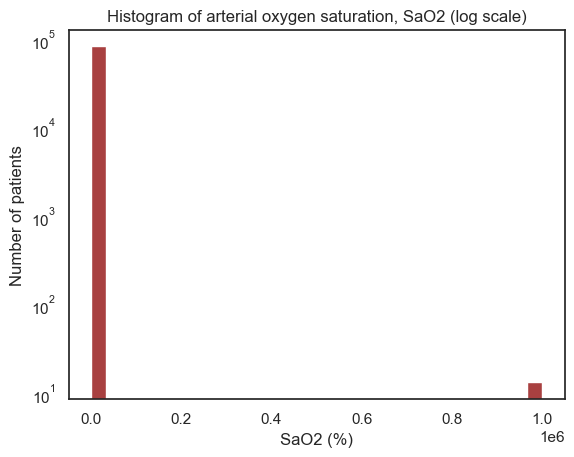

In [8]:
# Histogram of SaO2 values
# (arterial oxygen saturation - the 'true' O2 sat value for each patient)
# Use log scale for y-axis because low SaO2 values are less common
sns.histplot(df['SaO2'], bins=30, log_scale=[False,True], color='darkred');
plt.xlabel("SaO2 (%)")
plt.ylabel("Number of patients")
plt.title("Histogram of arterial oxygen saturation, SaO2 (log scale)");

In [9]:
# There is at least one erroneous SaO2 value, because maximum possible is 100
df.SaO2.max()

999999.0

In [10]:
# Therefore, remove SaO2 and SpO2 values that are above 100
df = df[(df['SaO2'] <= 100) & (df['SpO2'] <= 100)]

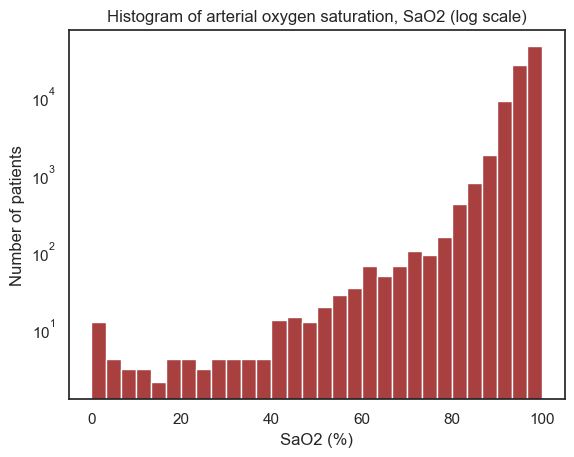

In [11]:
# Again, histogram of SaO2 values
sns.histplot(df['SaO2'], bins=30, log_scale=[False,True], color='darkred');
plt.xlabel("SaO2 (%)")
plt.ylabel("Number of patients")
plt.title("Histogram of arterial oxygen saturation, SaO2 (log scale)");

In [12]:
# There are quite a few SaO2 values that are erroenously low:
# a person cannot be alive with SaO2 of 50%, for example.
# Therefore, remove all SaO2 values lower than 70.
# Also remove all SpO2 values lower than 70, because those measurements would also be erroneous

In [13]:
df = df[(df['SaO2'] >= 70) & (df['SpO2'] >= 70)]

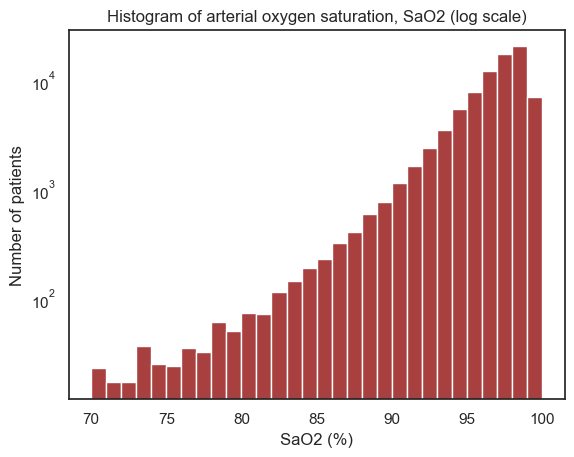

In [14]:
# Again, histogram of SaO2 values
sns.histplot(df['SaO2'], bins=30, log_scale=[False,True], color='darkred');
plt.xlabel("SaO2 (%)")
plt.ylabel("Number of patients")
plt.title("Histogram of arterial oxygen saturation, SaO2 (log scale)");

In [15]:
# ☝️Looks good

### Findings: SaO2 values
- SaO2 values in the healthy range (>= 95%) are overrepresented.
- Patients with hypoxemia (SaO2 < 88%) are underrepresented.
- We must account for this imbalance in our analyses.

# Explore range of values for most important feature, SpO2

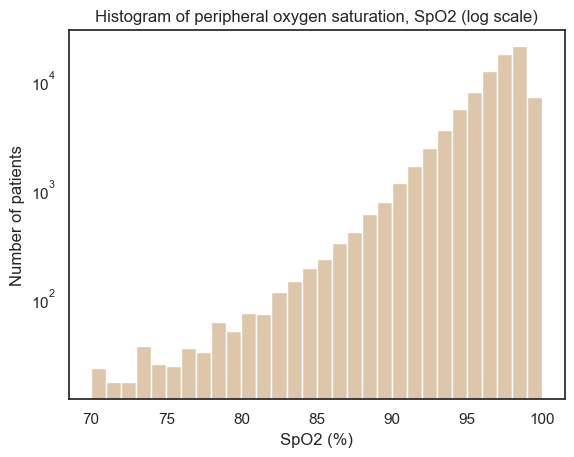

In [16]:
# Histogram of SpO2 values 
# (peripheral oxygen saturation - measured from fingertip pulse oximeter)
# Use log scale for y-axis because low SpO2 values are less common
sns.histplot(df['SaO2'], bins=30, log_scale=[False,True], color='tan');
plt.xlabel("SpO2 (%)")
plt.ylabel("Number of patients")
plt.title("Histogram of peripheral oxygen saturation, SpO2 (log scale)");

In [17]:
# ☝️Looks good

### Findings: SpO2 values
- SpO2 values in the healthy range (>= 95%) are overrepresented.
- Patients that would be classified as hypoxemia (SpO2 < 88%) are underrepresented.
- We must account for this imbalance in our analyses.

# Explore occurences of hidden hypoxemia (HH), the binary label we want to predict with classifier

In [18]:
df.hidden_hypoxemia = df.hidden_hypoxemia.astype('object')

# We see that 1.6% of patients in dataset have hidden hypoxemia (HH)
df.hidden_hypoxemia.value_counts(normalize=True)

0    0.983933
1    0.016067
Name: hidden_hypoxemia, dtype: float64

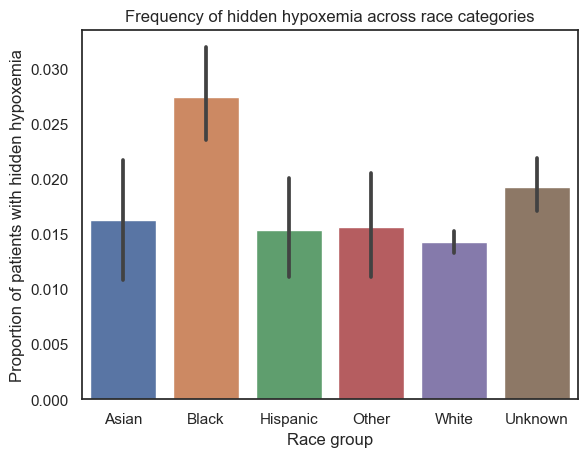

In [19]:
# View occurence of hidden hypoxemia by race group
sns.barplot(data=df, x='race_group', y='hidden_hypoxemia');
plt.xlabel("Race group")
plt.ylabel("Proportion of patients with hidden hypoxemia")
plt.title("Frequency of hidden hypoxemia across race categories");

### Findings: Hidden hypoxemia
- Only 1.6% of patients in dataset have hidden hypoxemia
    - The label we want to classify is highly unbalanced!
    - When splitting train and test datasets, we should always stratify on 'hidden_hypoxemia'
- Black patients are more likely to have hidden hypoxemia than other race groups
    - This makes sense, because oximeters tend to give inaccurately high readings for people with darker skin tones.

## Explore relationship between SpO2 (oximeter-measured O2 saturation) and SaO2 (blood-draw-measured O2 saturation)

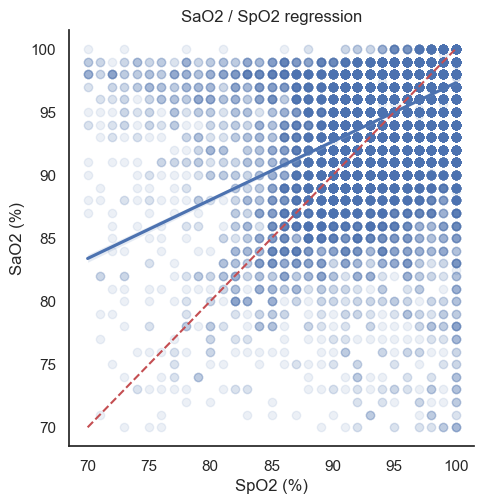

In [20]:
sns.lmplot(data = df, x = 'SpO2', y = 'SaO2', scatter_kws = {'alpha': 0.1})

plt.plot(np.linspace(70,100,100), np.linspace(70,100,100), 'r--')

plt.xlabel("SpO2 (%)")
plt.ylabel("SaO2 (%)")

plt.title("SaO2 / SpO2 regression");

If SpO2 was a good predictor of SaO2, all points would fall near the red y=x line. It is a problem that they do not.

**Unfortunately, this problem is worse for people with darker skin:**

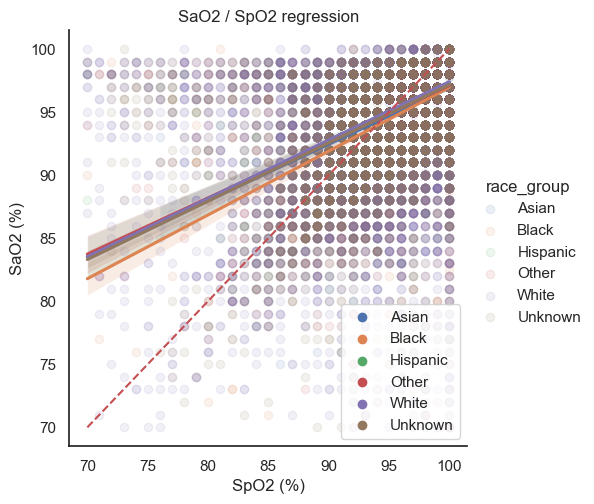

In [21]:
sns.lmplot(data = df, x = 'SpO2', y = 'SaO2', scatter_kws = {'alpha': 0.1}, hue = 'race_group')

plt.plot(np.linspace(70,100,100), np.linspace(70,100,100), 'r--')

leg = plt.legend(loc = 'lower right')
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.xlabel("SpO2 (%)")
plt.ylabel("SaO2 (%)")

plt.title("SaO2 / SpO2 regression");

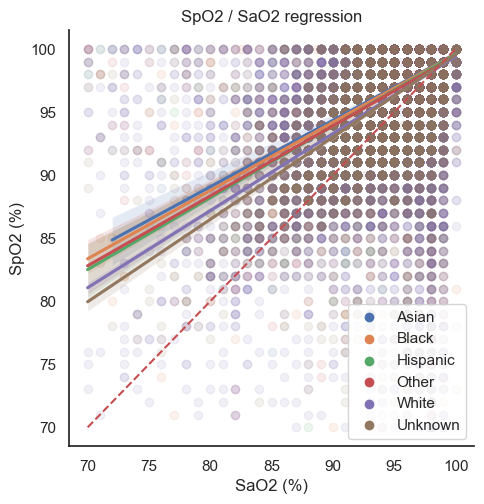

In [22]:
sns.lmplot(data = df,
           x = 'SaO2',
           y = 'SpO2',
           scatter_kws = {'alpha': 0.1},
           hue = 'race_group',
           legend = False)

plt.plot(np.linspace(70,100,100), np.linspace(70,100,100), 'r--')

leg = plt.legend(loc = 'lower right')
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.xlabel("SaO2 (%)")
plt.ylabel("SpO2 (%)")

plt.title("SpO2 / SaO2 regression");

### Findings: SpO2 / SaO2 relationship, by race
- On average, SpO2 readings from fingertip oximeters (y-axis) are higher than true blood oxygen saturation (SaO2, x-axis) for all patients (regression lines are above the red y=x line).
- For lower values of SaO2 (danger zone!) on x-axis, the regression lines shows patients of color (Asian, Black, Hispanic) get higher readings of SpO2 (y-axis) from fingertip oximeter than white people.
    - This means SpO2 readings are more likely to give misleadingly high values for patients of color.
- (Side note) Because the regression line for race = Unknown is closest to the regression line for race = White, we can hypothesize that many, if not most, patients of unknown race are white.